# 목적: visualize 및 평가 metric 계산

In [1]:
import argparse
import json
import os
import sys
import time

from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning, NumbaWarning
import warnings
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaWarning)

import numpy as np
import torch
from pathlib import Path
import yaml
from det3d import torchie
from det3d.datasets import build_dataloader, build_dataset
from det3d.models import build_detector
from det3d.torchie import Config
from det3d.torchie.apis import (
    batch_processor,
    build_optimizer,
    get_root_logger,
    init_dist,
    set_random_seed,
    train_detector,
)
from det3d.torchie.trainer import load_checkpoint
import torch.distributed as dist
import subprocess

# 주피터 노트북 경로설정
os.chdir('../')

def parse_args():
    parser = argparse.ArgumentParser(description="Train a detector")
    parser.add_argument("--config", default="configs/etriInfra/pp/etriInfra_centerpoint_pp_02voxel_two_pfn_10sweep.py", help="train config file path")
    parser.add_argument("--work_dir", help="the dir to save logs and models")
    parser.add_argument("--resume_from", help="the checkpoint file to resume from")
    parser.add_argument(
        "--validate",
        action="store_true",
        help="whether to evaluate the checkpoint during training",
    )
    parser.add_argument(
        "--gpus",
        type=int,
        default=1,
        help="number of gpus to use " "(only applicable to non-distributed training)",
    )
    parser.add_argument("--seed", type=int, default=None, help="random seed")
    parser.add_argument(
        "--launcher",
        choices=["pytorch", "slurm"],
        default="pytorch",
        help="job launcher",
    )
    parser.add_argument("--local_rank", type=int, default=0)
    parser.add_argument(
        "--autoscale-lr",
        action="store_true",
        help="automatically scale lr with the number of gpus",
    )
    args = parser.parse_args(args=[])
    if "LOCAL_RANK" not in os.environ:
        os.environ["LOCAL_RANK"] = str(args.local_rank)

    return args
args = parse_args()
cfg = Config.fromfile(args.config)
# distribution 설정 안함
cfg.local_rank = args.local_rank 

no apex
No Tensorflow
Deformable Convolution not built!
No APEX!


In [2]:
# init logger before other steps
distributed = False
cfg.gpus = args.gpus
logger = get_root_logger(cfg.log_level)
logger.info("Distributed training: {}".format(distributed))
logger.info(f"torch.backends.cudnn.benchmark: {torch.backends.cudnn.benchmark}")

2024-04-15 13:05:03,519 - INFO - Distributed training: False
2024-04-15 13:05:03,520 - INFO - torch.backends.cudnn.benchmark: False


In [3]:
model = build_detector(cfg.model, train_cfg=None, test_cfg=cfg.test_cfg)

2024-04-15 13:05:03,589 - INFO - Finish RPN Initialization
2024-04-15 13:05:03,589 - INFO - num_classes: [2, 2, 1, 1, 2, 1]
2024-04-15 13:05:03,606 - INFO - Finish CenterHead Initialization


Use HM Bias:  -2.19


In [4]:
args.testset = False
dataset = build_dataset(cfg.data.val)

In [5]:
args.speed_test = True
data_loader = build_dataloader(
        dataset,
        batch_size=cfg.data.samples_per_gpu if not args.speed_test else 1,
        workers_per_gpu=cfg.data.workers_per_gpu,
        dist=distributed,
        shuffle=False,
    )

In [6]:
args.checkpoint = "modelzoo/etri3D_pointpillar/etri3D_latest.pth"
checkpoint = load_checkpoint(model, args.checkpoint, map_location="cpu")

In [7]:
model = model.cuda()
model.eval()
mode = "val"

In [8]:
logger.info(f"work dir: {args.work_dir}")
if cfg.local_rank == 0:
    prog_bar = torchie.ProgressBar(len(data_loader.dataset) // cfg.gpus)

detections = {}
cpu_device = torch.device("cpu")

start = time.time()

start = int(len(dataset) / 3)
end = int(len(dataset) * 2 /3)

time_start = 0 
time_end = 0 

2024-04-15 13:05:05,254 - INFO - work dir: None


[                              ] 0/3000, elapsed: 0s, ETA:

In [9]:
input_output = {"points": [], "gt_boxes": [], "gt_classes": [], "output_boxes": [], "output_classes": [], "output_scores": []}
for i, data_batch in enumerate(data_loader):
    if i == start:
        torch.cuda.synchronize()
        time_start = time.time()

    if i == end:
        torch.cuda.synchronize()
        time_end = time.time()

    with torch.no_grad():
        outputs = batch_processor(
            model, data_batch, train_mode=False, local_rank=args.local_rank,
        )
    for j, output in enumerate(outputs):
        input_output["points"].append(data_batch['points'][j].cpu().numpy())
        gt_boxes = []
        for ts in data_batch['anno_box']:
            ts2 = ts[j]
            gt_boxes.extend(ts2.cpu().numpy())
        input_output["gt_boxes"].append(np.array(gt_boxes))
        gt_classes = []
        idx = 0
        for k in range(data_batch["anno_cls"][j].shape[0]):
            head_classes = cfg.tasks[k]
            class_names = head_classes['class_names']
            head_class_ids = data_batch['anno_cls'][j][k]
            for l in range(len(head_class_ids)):
                _id = head_class_ids[l] - 1
                gt_classes.append(idx+_id)
            idx += len(class_names)
        input_output["output_classes"].append(output['label_preds'].cpu().numpy())
        input_output["gt_classes"].append(np.array(gt_classes))
        input_output["output_boxes"].append(output["box3d_lidar"].cpu().numpy())
        input_output["output_scores"].append(output['scores'].cpu().numpy())

/home/jaelee/anaconda3/envs/centerpoint/lib/python3.8/site-packages/numpy/core/shape_base.py:420: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arrays = [asanyarray(arr) for arr in arrays]
/home/jaelee/anaconda3/envs/centerpoint/lib/python3.8/site-packages/numpy/core/shape_base.py:420: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arrays = [asanyarray(arr) for arr in arrays]
/home/jaelee/anaconda3/envs/centerpoint/lib/python3.8/site-packages/numpy/core/shape_base.py:420: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (whi

In [11]:
import open3d as o3d
from open3d.web_visualizer import draw
i = 0
points_v = input_output["points"][i]
gt_boxes = input_output["gt_boxes"][i]
pred_boxes = input_output["output_boxes"][i]
scores = input_output["output_scores"][i]
mesh_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=2, origin=[0,0,0])
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points_v)
entities_to_draw = [pcd, mesh_frame]

# pred_boxes 그리기
for idx in range(len(pred_boxes)):
        if scores[idx] <= 0.2:
                continue
        translation = pred_boxes[idx][:3]
        w, l, h = pred_boxes[idx][3], pred_boxes[idx][4], pred_boxes[idx][5]
        rotation = pred_boxes[idx][-1]

        bounding_box = np.array([
                        [-l/2, -l/2, l/2, l/2, -l/2, -l/2, l/2, l/2],
                        [w/2, -w/2, -w/2, w/2, w/2, -w/2, -w/2, w/2],
                        [-h/2, -h/2, -h/2, -h/2, h/2, h/2, h/2, h/2]]) 
        rotation_matrix = np.array([
                [np.cos(rotation), -np.sin(rotation), 0.0],
                [np.sin(rotation), np.cos(rotation), 0.0],
                [0.0, 0.0, 1.0]])
        eight_points = np.tile(translation, (8, 1))

        corner_box = np.dot(rotation_matrix, bounding_box) + eight_points.transpose()
        boxes3d_pts = corner_box.transpose()
        boxes3d_pts = boxes3d_pts.T
        boxes3d_pts = o3d.utility.Vector3dVector(boxes3d_pts.T)
        box = o3d.geometry.OrientedBoundingBox.create_from_points(boxes3d_pts)
        box.color = [1, 0, 0]           #Box color would be red box.color = [R,G,B]
        entities_to_draw.append(box)
        
# gt_boxes 그리기
for idx in range(len(gt_boxes)):
        translation = gt_boxes[idx][:3]
        w, l, h = gt_boxes[idx][3], gt_boxes[idx][4], gt_boxes[idx][5]
        rotation = gt_boxes[idx][-1]

        bounding_box = np.array([
                        [-l/2, -l/2, l/2, l/2, -l/2, -l/2, l/2, l/2],
                        [w/2, -w/2, -w/2, w/2, w/2, -w/2, -w/2, w/2],
                        [-h/2, -h/2, -h/2, -h/2, h/2, h/2, h/2, h/2]]) 
        rotation_matrix = np.array([
                [np.cos(rotation), -np.sin(rotation), 0.0],
                [np.sin(rotation), np.cos(rotation), 0.0],
                [0.0, 0.0, 1.0]])
        eight_points = np.tile(translation, (8, 1))

        corner_box = np.dot(rotation_matrix, bounding_box) + eight_points.transpose()
        boxes3d_pts = corner_box.transpose()
        boxes3d_pts = boxes3d_pts.T
        boxes3d_pts = o3d.utility.Vector3dVector(boxes3d_pts.T)
        box = o3d.geometry.OrientedBoundingBox.create_from_points(boxes3d_pts)
        box.color = [0, 1, 0]           #Box color would be red box.color = [R,G,B]
        entities_to_draw.append(box)
draw([*entities_to_draw])

[Open3D INFO] Window window_1 created.


WebVisualizer(window_uid='window_1')

[Open3D INFO] Sending init frames to window_1.


In [12]:
import glob
import os
import sys
import time
import numpy as np
import matplotlib.pyplot as plt

In [13]:
class EvalResult:
    def __init__(self, cfg, max_range, min_score, distance_threshold, save_loc):
        # cls_int2name: cls 고유번호에서 이름으로 변환하는 딕셔너리
        self.cls_int2name = {}
        idx = 0
        for i in range(len(cfg.tasks)):
            head_classes = cfg.tasks[i]
            class_names = head_classes['class_names']
            for j, name in enumerate(class_names):
                self.cls_int2name[idx+j] = name
            idx += len(class_names)
        
        self.results_dict = {}
        self.classes = [v for v in self.cls_int2name.values()]
        for single_class in self.classes:
            class_dict = {}
            class_dict['class'] = single_class
            class_dict['T_p'] = np.empty((0, 8))
            class_dict['gt'] = np.empty((0, 7))
            class_dict['total_N_pos'] = 0
            class_dict['result'] = np.empty((0, 2))
            class_dict['precision'] = []
            class_dict['recall'] = []
            self.results_dict[single_class] = class_dict
        
        self.total_N_pos = 0
        self.max_range = max_range
        self.score_threshold = min_score
        self.distance_threshold_sq = distance_threshold**2
        self.save_loc = save_loc

    def compute_ap_curve(self, class_dict):
        t_pos = 0
        class_dict['precision'] = np.ones(class_dict['result'].shape[0]+2)
        class_dict['recall'] = np.zeros(class_dict['result'].shape[0]+2)
        sorted_detections = class_dict['result'][(-class_dict['result'][:, 1]).argsort(), :]
        print(sorted_detections.shape)
        for i, (result_bool, result_score) in enumerate(sorted_detections):
            if result_bool == 1:
                t_pos += 1
            class_dict['precision'][i+1] = t_pos / (i + 1)
            class_dict['recall'][i+1] = t_pos / class_dict['total_N_pos']
        class_dict['precision'][i+2] = 0
        class_dict['recall'][i+2] = class_dict['recall'][i+1]

        ## Plot
        plt.figure()
        plt.plot(class_dict['recall'], class_dict['precision'])
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision Recall curve for {} Class'.format(class_dict['class']))
        plt.xlim([0, 1])
        plt.ylim([0, 1.05])
        plt.savefig(self.save_loc + class_dict['class'] + "_pr_curve.png")

    def compute_f1_score(self, precision, recall):
        p, r = precision[(precision+recall) > 0], recall[(precision+recall) > 0]
        f1_scores = 2 * p * r / (p + r)
        return np.max(f1_scores)

    def compute_mean_ap(self, precision, recall, precision_threshold=0.0, recall_threshold=0.0):
        mean_ap = 0
        threshold_mask = np.logical_and(precision > precision_threshold,
                                        recall > recall_threshold)
        # calculate mean AP
        precision = precision[threshold_mask]
        recall = recall[threshold_mask]
        recall_diff = np.diff(recall)
        precision_diff = np.diff(precision)
        # Square area under curve based on i+1 precision, then linear difference in precision
        mean_ap = np.sum(precision[1:]*recall_diff + recall_diff*precision_diff/2)
        # We need to divide by (1-recall_threshold) to make the max possible mAP = 1. In practice threshold by the first
        # considered recall value (threshold = 0.1 -> first considered value may be = 0.1123)
        mean_ap = mean_ap/(1-recall[0])
        return mean_ap

    def compute_ate2d(self, predictions, ground_truth):
        # euclidean distance 3d
        mean_ate2d = np.mean(np.sqrt((predictions[:, 0] - ground_truth[:, 0])**2 +
                                     (predictions[:, 1] - ground_truth[:, 1])**2))
        return mean_ate2d

    def compute_ate3d(self, predictions, ground_truth):
        # euclidean distance 2d
        mean_ate3d = np.mean(np.sqrt((predictions[:, 0] - ground_truth[:, 0]) ** 2 +
                                     (predictions[:, 1] - ground_truth[:, 1]) ** 2 +
                                     (predictions[:, 2] - ground_truth[:, 2]) ** 2))
        return mean_ate3d

    def compute_ase(self, predictions, ground_truth):
        # simplified iou where boxes are centered and aligned with eachother
        pred_vol = predictions[:, 3:6]
        gt_vol = ground_truth[:, 3:6]
        iou3d = np.mean(1 - np.prod(np.minimum(pred_vol, gt_vol), axis=1)/np.prod(np.maximum(pred_vol, gt_vol), axis=1))
        return iou3d

    def compute_aoe(self, predictions, ground_truth):
        err = ground_truth[:,6] - predictions[:,6]
        aoe = np.mean(np.abs((err + np.pi) % (2*np.pi) - np.pi))
        return aoe

    def output_to_evalform(self, cls_array, box_array, pred_score = None):
        # class_id, x, y, z, l, w, h, r 순으로 배열 구성
        N = cls_array.shape[0]
        if pred_score is not None:
            o_ary = np.zeros((N, 9))
        else:
            o_ary = np.zeros((N, 8))
        for i in range(N):
            o_ary[i][0] = cls_array[i]
            o_ary[i][1] = box_array[i][0]
            o_ary[i][2] = box_array[i][1]
            o_ary[i][3] = box_array[i][2]
            o_ary[i][4] = box_array[i][4]
            o_ary[i][5] = box_array[i][3]
            o_ary[i][6] = box_array[i][5]
            o_ary[i][7] = box_array[i][-1]
            if pred_score is not None:
                o_ary[i][8] = pred_score[i]
        return o_ary

    def match_pairs(self, pred_label, gt_label):
        true_preds = np.empty((0, 8))
        corresponding_gt = np.empty((0, 7))
        result_score = np.empty((0, 2))
        # Initialize matching loop
        match_incomplete = True
        while match_incomplete and gt_label.shape[0] > 0:
            match_incomplete = False
            for gt_idx, single_gt_label in enumerate(gt_label):
                # Check is any prediction is in range
                distance_sq_array = (single_gt_label[0] - pred_label[:, 0])**2 + (single_gt_label[1] - pred_label[:, 1])**2
                # If there is a prediction in range, pick closest
                if np.any(distance_sq_array < self.distance_threshold_sq):
                    min_idx = np.argmin(distance_sq_array)
                    # Store true prediction
                    true_preds = np.vstack((true_preds, pred_label[min_idx, :].reshape(-1, 1).T))
                    corresponding_gt = np.vstack((corresponding_gt, gt_label[gt_idx]))

                    # Store score for mAP
                    result_score = np.vstack((result_score, np.array([[1, pred_label[min_idx, 7]]])))

                    # Remove prediction and gt then reset loop
                    pred_label = np.delete(pred_label, obj=min_idx, axis=0)
                    gt_label = np.delete(gt_label, obj=gt_idx, axis=0)
                    match_incomplete = True
                    break

        # If there were any false detections, add them.
        if pred_label.shape[0] > 0:
            false_positives = np.zeros((pred_label.shape[0], 2))
            false_positives[:, 1] = pred_label[:, 7]
            result_score = np.vstack((result_score, false_positives))
        return true_preds, corresponding_gt, result_score

    def eval_pair(self, pred_label, gt_label):
        ## Check
        assert pred_label.shape[1] == 9
        assert gt_label.shape[1] == 8
        if pred_label.shape[0] > 0:
            pred_label = pred_label[pred_label[:, 8].astype(np.float32) > self.score_threshold, :]
        
        for single_class in self.classes:
            # get all pred labels, order by score
            class_pred_label = pred_label[np.array([self.cls_int2name[v.astype(np.int32)] == single_class for v in pred_label[:, 0]]), 1:]
            score = class_pred_label[:, 7].astype(np.float32)
            class_pred_label = class_pred_label[(-score).argsort(), :].astype(np.float32) # sort decreasing
            
            
            # add gt label length to total_N_pos
            class_gt_label = gt_label[np.array([self.cls_int2name[v.astype(np.int32)] == single_class for v in gt_label[:, 0]]), 1:].astype(np.float32)

            self.results_dict[single_class]['total_N_pos'] += class_gt_label.shape[0]

            # match pairs
            pred_array, gt_array, result_score_pair = self.match_pairs(class_pred_label, class_gt_label)

            # add to existing results
            self.results_dict[single_class]['T_p'] = np.vstack((self.results_dict[single_class]['T_p'], pred_array))
            self.results_dict[single_class]['gt'] = np.vstack((self.results_dict[single_class]['gt'], gt_array))
            self.results_dict[single_class]['result'] = np.vstack((self.results_dict[single_class]['result'],
                                                                   result_score_pair))
    def evaluate(self, input_output):
        print("Evaluation examples")
        for i in range(len(input_output["output_boxes"])):
            predictions = self.output_to_evalform(input_output["output_classes"][i], input_output["output_boxes"][i], 
                                                input_output["output_scores"][i])
            ground_truth = self.output_to_evalform(input_output["gt_classes"][i], input_output["gt_boxes"][i])
            
            self.eval_pair(predictions, ground_truth)
        print("\nDone!")
        print("----------------------------------")
        ## Calculate
        for single_class in self.classes:
            class_dict = self.results_dict[single_class]
            print("Calculating metrics for {} class".format(single_class))
            print("----------------------------------")
            print("Number of ground truth labels: ", class_dict['total_N_pos'])
            print("Number of detections:  ", class_dict['result'].shape[0])
            print("Number of true positives:  ", np.sum(class_dict['result'][:, 0] == 1))
            print("Number of false positives:  ", np.sum(class_dict['result'][:, 0] == 0))
            if class_dict['total_N_pos'] == 0:
                print("No detections for this class!")
                print(" ")
                continue
            ## AP
            self.compute_ap_curve(class_dict)
            mean_ap = self.compute_mean_ap(class_dict['precision'], class_dict['recall'])
            print('Mean AP: %.3f ' % mean_ap)
            f1 = self.compute_f1_score(class_dict['precision'], class_dict['recall'])
            print('F1 Score: %.3f ' % f1)
            print(' ')
            ## Positive Thresholds
            # ATE 2D
            ate2d = self.compute_ate2d(class_dict['T_p'], class_dict['gt'])
            print('Average 2D Translation Error [m]:  %.4f ' % ate2d)
            # ATE 3D
            ate3d = self.compute_ate3d(class_dict['T_p'], class_dict['gt'])
            print('Average 3D Translation Error [m]:  %.4f ' % ate3d)
            # ASE
            ase = self.compute_ase(class_dict['T_p'], class_dict['gt'])
            print('Average Scale Error:  %.4f ' % ase)
            # AOE
            aoe = self.compute_aoe(class_dict['T_p'], class_dict['gt'])
            print('Average Orientation Error [rad]:  %.4f ' % aoe)
            print(" ")

In [14]:
evaluate = EvalResult(cfg, max_range=0.0, min_score=0.0, distance_threshold=1.0, save_loc="work_dirs/")

Evaluation examples

Done!
----------------------------------
Calculating metrics for car class
----------------------------------
Number of ground truth labels:  31092
Number of detections:   38358
Number of true positives:   26339
Number of false positives:   12019
(38358, 2)
Mean AP: 0.846 
F1 Score: 0.904 
 
Average 2D Translation Error [m]:  0.1034 
Average 3D Translation Error [m]:  0.1229 
Average Scale Error:  0.0882 
Average Orientation Error [rad]:  0.4069 
 
Calculating metrics for personal_mobility class
----------------------------------
Number of ground truth labels:  0
Number of detections:   3036
Number of true positives:   0
Number of false positives:   3036
No detections for this class!
 
Calculating metrics for truck class
----------------------------------
Number of ground truth labels:  703
Number of detections:   1203
Number of true positives:   641
Number of false positives:   562
(1203, 2)
Mean AP: 0.906 
F1 Score: 0.929 
 
Average 2D Translation Error [m]:  0.0

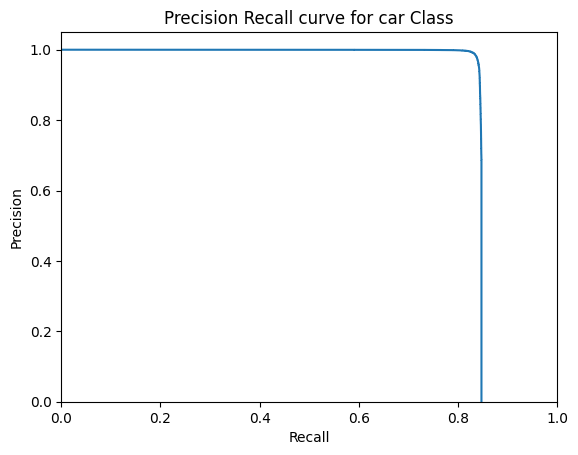

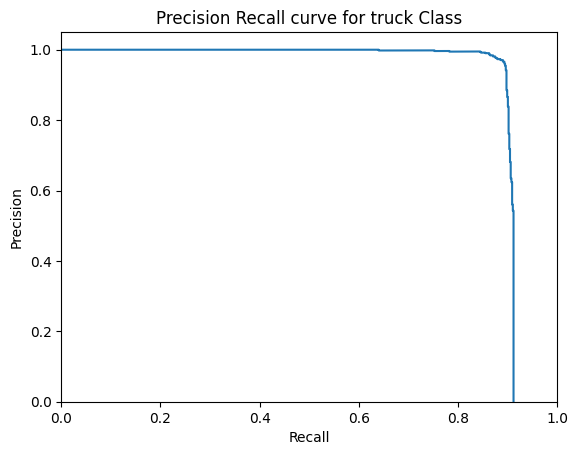

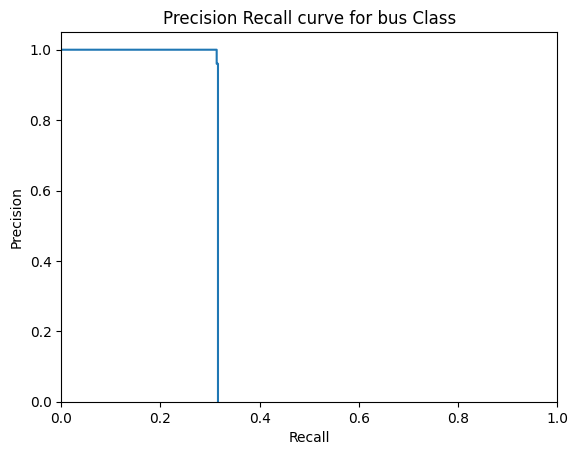

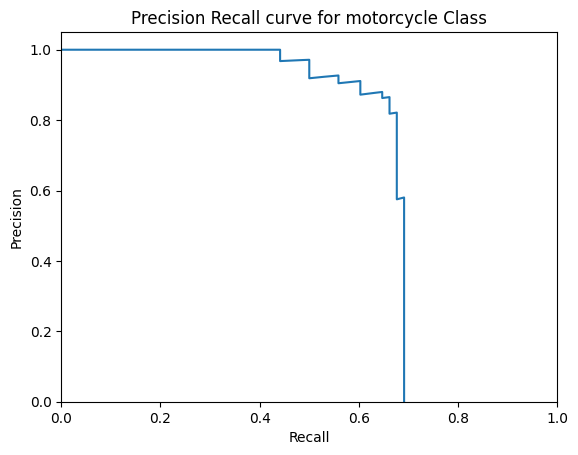

[010:374][877043] (stun_port.cc:96): Binding request timed out from 10.42.0.x:34317 (enp5s0)
[010:374][877043] (stun_port.cc:96): Binding request timed out from 10.42.0.x:34317 (enp5s0)


In [15]:
evaluate.evaluate(input_output)

In [ ]:
# def pt_to_xyz(fp):
#     x = []
#     y = []
#     z = []
#     # fp = np.fromfile(fname, dtype=np.float32)
#     # fp = fp.reshape(-1,3)
#     for i in range(fp.shape[0]):
#         x.append(fp[i][0])
#         y.append(fp[i][1])
#         z.append(fp[i][2])
#     return x,y,z

# def writePCDFile(fname,x,y,z):
#     numPoints= len(x)
#     with open(fname, 'w') as fp:
#         fp.write("VERSION 0.7\n")
#         fp.write("FIELDS x y z\n")
#         fp.write("SIZE 4 4 4\n")
#         fp.write("TYPE F F F\n")
#         fp.write("WIDTH "+str(numPoints)+"\n")
#         fp.write("HEIGHT 1\n")
#         fp.write("POINTS "+str(numPoints)+"\n")
#         fp.write("DATA ascii\n")
#         for index in range(numPoints):
#             txtLine = "{} {} {}\n".format(x[index],y[index],z[index] )
#             fp.write(txtLine)
#         pass
# rt = "/home/jaelee/objdect/CenterPoint/etri3Deval"
# x,y,z =pt_to_xyz(data_batch['points'][0].cpu().numpy())
# idx_p = 0
# pth = Path(f"ex{idx_p}")
# pcd_name = rt / pth.with_suffix('.pcd')
# writePCDFile(pcd_name,x,y,z)

### visualize


In [23]:
def pt_to_xyz(fp):
    x = []
    y = []
    z = []
    # fp = np.fromfile(fname, dtype=np.float32)
    # fp = fp.reshape(-1,3)
    for i in range(fp.shape[0]):
        x.append(fp[i][0])
        y.append(fp[i][1])
        z.append(fp[i][2])
    return x,y,z

def writePCDFile(fname,x,y,z):
    numPoints= len(x)
    with open(fname, 'w') as fp:
        fp.write("VERSION 0.7\n")
        fp.write("FIELDS x y z\n")
        fp.write("SIZE 4 4 4\n")
        fp.write("TYPE F F F\n")
        fp.write("WIDTH "+str(numPoints)+"\n")
        fp.write("HEIGHT 1\n")
        fp.write("POINTS "+str(numPoints)+"\n")
        fp.write("DATA ascii\n")
        for index in range(numPoints):
            txtLine = "{} {} {}\n".format(x[index],y[index],z[index] )
            fp.write(txtLine)
        pass


In [24]:
rt = "/home/jaelee/objdect/CenterPoint/etri3Deval"
x,y,z =pt_to_xyz(data_batch['points'][0].cpu().numpy())
idx_p = 0
pth = Path(f"ex{idx_p}")
pcd_name = rt / pth.with_suffix('.pcd')
writePCDFile(pcd_name,x,y,z)

In [25]:
pred_boxes = output['box3d_lidar'].cpu().numpy()

In [26]:
import open3d as o3d
from open3d.web_visualizer import draw
points_v = data_batch["points"][0]
mesh_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=2, origin=[0,0,0])
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points_v)
entities_to_draw = [pcd, mesh_frame]
# for idx in range(gt_boxes.shape[0]):
# idx = 0
for idx in range(len(pred_boxes)):
        if output['scores'].cpu().numpy()[idx] <= 0.2:
                continue
        translation = pred_boxes[idx][:3]
        w, l, h = pred_boxes[idx][3], pred_boxes[idx][4], pred_boxes[idx][5]
        rotation = pred_boxes[idx][-1]

        bounding_box = np.array([
                        [-l/2, -l/2, l/2, l/2, -l/2, -l/2, l/2, l/2],
                        [w/2, -w/2, -w/2, w/2, w/2, -w/2, -w/2, w/2],
                        [-h/2, -h/2, -h/2, -h/2, h/2, h/2, h/2, h/2]]) 
        rotation_matrix = np.array([
                [np.cos(rotation), -np.sin(rotation), 0.0],
                [np.sin(rotation), np.cos(rotation), 0.0],
                [0.0, 0.0, 1.0]])
        eight_points = np.tile(translation, (8, 1))

        corner_box = np.dot(rotation_matrix, bounding_box) + eight_points.transpose()
        boxes3d_pts = corner_box.transpose()
        boxes3d_pts = boxes3d_pts.T
        boxes3d_pts = o3d.utility.Vector3dVector(boxes3d_pts.T)
        box = o3d.geometry.OrientedBoundingBox.create_from_points(boxes3d_pts)
        box.color = [1, 0, 0]           #Box color would be red box.color = [R,G,B]
        entities_to_draw.append(box)
draw([*entities_to_draw])


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[Open3D INFO] Resetting default logger to print to terminal.
[Open3D INFO] Window window_0 created.
[Open3D INFO] EGL headless mode enabled.
[Open3D INFO] ICE servers: ["stun:stun.l.google.com:19302", "turn:user:password@34.69.27.100:3478", "turn:user:password@34.69.27.100:3478?transport=tcp"]
FEngine (64 bits) created at 0x7f469c00a5c0 (threading is enabled)
[Open3D INFO] Set WEBRTC_STUN_SERVER environment variable add a customized WebRTC STUN server.
[Open3D INFO] WebRTC Jupyter handshake mode enabled.
EGL(1.5)
OpenGL(4.1)


WebVisualizer(window_uid='window_0')

[Open3D INFO] Sending init frames to window_0.


In [85]:
data_batch['anno_box']

[tensor([[[-2.6418e+01,  4.0977e+00,  5.0232e-01,  2.1176e+00,  4.2946e+00,
            1.9041e+00,  0.0000e+00,  0.0000e+00, -4.0526e-01],
          [-2.4271e+01, -6.3866e+00, -4.5998e-01,  2.0639e+00,  4.8000e+00,
            1.4675e+00,  0.0000e+00,  0.0000e+00, -4.3944e-01],
          [-3.0731e+01, -5.4525e-02,  1.6352e-01,  2.1337e+00,  4.0709e+00,
            1.5520e+00,  0.0000e+00,  0.0000e+00, -3.2496e-01],
          [-3.3297e+01, -2.6228e+00,  2.7764e-02,  2.1313e+00,  4.6480e+00,
            1.6065e+00,  0.0000e+00,  0.0000e+00, -2.9202e-01],
          [ 1.1769e+01,  2.8165e+00, -1.0595e+00,  2.2000e+00,  5.2000e+00,
            1.5000e+00,  0.0000e+00,  0.0000e+00, -2.3089e+00],
          [-1.8377e+01,  3.4050e+00, -1.0897e-01,  2.0636e+00,  4.6314e+00,
            1.8000e+00,  0.0000e+00,  0.0000e+00, -1.0142e+00],
          [ 3.2146e+01,  2.3866e+01, -9.6893e-01,  2.1237e+00,  4.7618e+00,
            1.8000e+00,  0.0000e+00,  0.0000e+00, -2.3182e+00],
          [-2.5798e+

In [88]:
data_batch

{'metadata': [{'image_prefix': PosixPath('data/etri3Dobj_infra_edge'),
   'num_point_features': 3}],
 'points': [tensor([[-3.0760e-04,  1.4686e-01,  3.9207e-02],
          [ 1.2478e-04,  1.4299e-01,  3.8175e-02],
          [ 6.5157e-04,  1.6231e-01,  4.3334e-02],
          ...,
          [-1.8865e-03,  1.4606e-01, -4.2040e-02],
          [-1.2774e-03,  1.3069e-01, -3.7614e-02],
          [-8.9228e-04,  1.3454e-01, -3.8721e-02]])],
 'voxels': tensor([[[-3.0760e-04,  1.4686e-01,  3.9207e-02],
          [-5.6092e-02,  1.8087e-01,  5.0557e-02],
          [-5.6657e-02,  1.8474e-01,  5.1588e-02],
          ...,
          [-3.7470e-02,  1.6586e-01,  4.5398e-02],
          [-3.2750e-02,  1.4712e-01,  4.0239e-02],
          [-3.6428e-02,  1.6610e-01,  4.5398e-02]],
 
         [[ 1.2478e-04,  1.4299e-01,  3.8175e-02],
          [ 6.5157e-04,  1.6231e-01,  4.3334e-02],
          [ 1.0785e-03,  1.5072e-01,  4.0239e-02],
          ...,
          [ 8.5964e-03,  1.5822e-01,  4.2303e-02],
          [ 

In [27]:
gt_boxes = []
for ts in data_batch['anno_box']:
    ts = ts[0]
    gt_boxes.extend(ts.cpu().numpy())
points_v = data_batch["points"][0]
mesh_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=2, origin=[0,0,0])
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points_v)
entities_to_draw = [pcd, mesh_frame]
# for idx in range(gt_boxes.shape[0]):
# idx = 0
for idx in range(len(gt_boxes)):
        translation = gt_boxes[idx][:3]
        w, l, h = gt_boxes[idx][3], gt_boxes[idx][4], gt_boxes[idx][5]
        rotation = gt_boxes[idx][-1]

        bounding_box = np.array([
                        [-l/2, -l/2, l/2, l/2, -l/2, -l/2, l/2, l/2],
                        [w/2, -w/2, -w/2, w/2, w/2, -w/2, -w/2, w/2],
                        [-h/2, -h/2, -h/2, -h/2, h/2, h/2, h/2, h/2]]) 
        rotation_matrix = np.array([
                [np.cos(rotation), -np.sin(rotation), 0.0],
                [np.sin(rotation), np.cos(rotation), 0.0],
                [0.0, 0.0, 1.0]])
        eight_points = np.tile(translation, (8, 1))

        corner_box = np.dot(rotation_matrix, bounding_box) + eight_points.transpose()
        boxes3d_pts = corner_box.transpose()
        boxes3d_pts = boxes3d_pts.T
        boxes3d_pts = o3d.utility.Vector3dVector(boxes3d_pts.T)
        box = o3d.geometry.OrientedBoundingBox.create_from_points(boxes3d_pts)
        box.color = [0, 1, 0]           #Box color would be red box.color = [R,G,B]
        entities_to_draw.append(box)
draw([*entities_to_draw])


[Open3D INFO] Window window_1 created.


WebVisualizer(window_uid='window_1')

[Open3D INFO] Sending init frames to window_1.


### metric evaluation

In [33]:
cfg.tasks

[{'num_class': 2, 'class_names': ['car', 'personal_mobility']},
 {'num_class': 2, 'class_names': ['truck', 'construction_vehicle']},
 {'num_class': 1, 'class_names': ['bus']},
 {'num_class': 1, 'class_names': ['ground_animal']},
 {'num_class': 2, 'class_names': ['motorcycle', 'bicycle']},
 {'num_class': 1, 'class_names': ['pedestrian']}]

In [34]:
data_batch['anno_cls']

array([[array([1, 1, 1, 1, 1, 1, 1, 1], dtype=int32),
        array([], dtype=int32), array([], dtype=int32),
        array([], dtype=int32), array([], dtype=int32),
        array([], dtype=int32)]], dtype=object)

In [35]:
# cls_int2name: cls 고유번호에서 이름으로 변환하는 딕셔너리
cls_int2name = {}
idx = 0
for i in range(len(cfg.tasks)):
    head_classes = cfg.tasks[i]
    class_names = head_classes['class_names']
    for j, name in enumerate(class_names):
        cls_int2name[idx+j] = name
    idx += len(class_names)
cls_int2name

{0: 'car',
 1: 'personal_mobility',
 2: 'truck',
 3: 'construction_vehicle',
 4: 'bus',
 5: 'ground_animal',
 6: 'motorcycle',
 7: 'bicycle',
 8: 'pedestrian'}

In [90]:
data_batch['anno_cls'].shape

(1, 6)

In [36]:
data_batch['anno_cls'][0]

array([array([1, 1, 1, 1, 1, 1, 1, 1], dtype=int32),
       array([], dtype=int32), array([], dtype=int32),
       array([], dtype=int32), array([], dtype=int32),
       array([], dtype=int32)], dtype=object)

In [37]:
# data_batch['anno_cls'] 변환
input_cls_id = []
idx = 0
for i in range(data_batch['anno_cls'][0].shape[0]):
    head_classes = cfg.tasks[i]
    class_names = head_classes['class_names']
    head_class_ids = data_batch['anno_cls'][0][i]
    for j in range(len(head_class_ids)):
        _id = head_class_ids[j] - 1
        input_cls_id.append(idx+_id)
    idx += len(class_names)
input_cls_id = np.array(input_cls_id)
input_cls_id

array([0, 0, 0, 0, 0, 0, 0, 0])

In [39]:
distance_threshold = 1.0
save_loc = 'work_dirs/'
distance_threshold_sq = distance_threshold**2
score_threshold = min_score = 0.0
max_range = max_range = 0.0
classes = [v for v in cls_int2name.values()]
total_N_pos = 0
results_dict = {}
for single_class in classes:
    class_dict = {}
    class_dict['class'] = single_class
    class_dict['T_p'] = np.empty((0, 8))
    class_dict['gt'] = np.empty((0, 7))
    class_dict['total_N_pos'] = 0
    class_dict['result'] = np.empty((0, 2))
    class_dict['precision'] = []
    class_dict['recall'] = []
    results_dict[single_class] = class_dict
time = time.time()
# self.evaluate(pred_label_path, gt_label_path, label_format)
# file_parsing: class_id, x, y, z, l, w, h, r 순으로 배열 구성

def output_to_evalform(cls_array, box_array, pred_score = None):
    # class_id, x, y, z, l, w, h, r 순으로 배열 구성
    N = cls_array.shape[0]
    if pred_score is not None:
        o_ary = np.zeros((N, 9))
    else:
        o_ary = np.zeros((N, 8))
    for i in range(N):
        o_ary[i][0] = cls_array[i]
        o_ary[i][1] = box_array[i][0]
        o_ary[i][2] = box_array[i][1]
        o_ary[i][3] = box_array[i][2]
        o_ary[i][4] = box_array[i][4]
        o_ary[i][5] = box_array[i][3]
        o_ary[i][6] = box_array[i][5]
        o_ary[i][7] = box_array[i][-1]
        if pred_score is not None:
            o_ary[i][8] = pred_score[i]
    return o_ary
predictions = output_to_evalform(output['label_preds'].cpu().numpy(), output['box3d_lidar'].cpu().numpy(), output['scores'].cpu().numpy())
ground_truth = output_to_evalform(input_cls_id, np.stack(gt_boxes))

In [13]:
output['label_preds']

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 6, 6, 6, 8, 8, 8],
       device='cuda:0')

In [42]:
predictions.shape, ground_truth.shape

((18, 9), (8, 8))

In [43]:
def match_pairs(pred_label, gt_label):
    true_preds = np.empty((0, 8))
    corresponding_gt = np.empty((0, 7))
    result_score = np.empty((0, 2))
    # Initialize matching loop
    match_incomplete = True
    while match_incomplete and gt_label.shape[0] > 0:
        match_incomplete = False
        for gt_idx, single_gt_label in enumerate(gt_label):
            # Check is any prediction is in range
            distance_sq_array = (single_gt_label[0] - pred_label[:, 0])**2 + (single_gt_label[1] - pred_label[:, 1])**2
            # If there is a prediction in range, pick closest
            if np.any(distance_sq_array < distance_threshold_sq):
                min_idx = np.argmin(distance_sq_array)
                # Store true prediction
                true_preds = np.vstack((true_preds, pred_label[min_idx, :].reshape(-1, 1).T))
                corresponding_gt = np.vstack((corresponding_gt, gt_label[gt_idx]))

                # Store score for mAP
                result_score = np.vstack((result_score, np.array([[1, pred_label[min_idx, 7]]])))

                # Remove prediction and gt then reset loop
                pred_label = np.delete(pred_label, obj=min_idx, axis=0)
                gt_label = np.delete(gt_label, obj=gt_idx, axis=0)
                match_incomplete = True
                break
    # If there were any false detections, add them.
    if pred_label.shape[0] > 0:
        false_positives = np.zeros((pred_label.shape[0], 2))
        false_positives[:, 1] = pred_label[:, 7]
        result_score = np.vstack((result_score, false_positives))
    return true_preds, corresponding_gt, result_score

def eval_pair(pred_label, gt_label, results_dict):
    ## Check
    assert pred_label.shape[1] == 9
    assert gt_label.shape[1] == 8

    ## Threshold score
    if pred_label.shape[0] > 0:
        pred_label = pred_label[pred_label[:, 8].astype(np.float) > score_threshold, :]

    for single_class in classes:
        # get all pred labels, order by score
        class_pred_label = pred_label[np.char.lower(pred_label[:, 0].astype(str)) == single_class, 1:]
        score = class_pred_label[:, 7].astype(np.float)
        class_pred_label = class_pred_label[(-score).argsort(), :].astype(np.float) # sort decreasing

        # add gt label length to total_N_pos
        class_gt_label = gt_label[np.char.lower(gt_label[:, 0].astype(str)) == single_class, 1:].astype(np.float)
        results_dict[single_class]['total_N_pos'] += class_gt_label.shape[0]

        # match pairs
        pred_array, gt_array, result_score_pair = match_pairs(class_pred_label, class_gt_label)
        
        # add to existing results
        results_dict[single_class]['T_p'] = np.vstack((results_dict[single_class]['T_p'], pred_array))
        results_dict[single_class]['gt'] = np.vstack((results_dict[single_class]['gt'], gt_array))
        results_dict[single_class]['result'] = np.vstack((results_dict[single_class]['result'], result_score_pair))
    return results_dict
results_dict = eval_pair(predictions, ground_truth, results_dict)

/tmp/ipykernel_867164/1980593778.py:41: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_label = pred_label[pred_label[:, 8].astype(np.float) > score_threshold, :]
/tmp/ipykernel_867164/1980593778.py:46: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  score = class_pred_label[:, 7].astype(np.float)
/tmp/ipykernel_867164/1980593778.py:47: 

In [46]:
# eval_pair
pred_label = predictions
gt_label = ground_truth
results_dict = {}
for single_class in classes:
    class_dict = {}
    class_dict['class'] = single_class
    class_dict['T_p'] = np.empty((0, 8))
    class_dict['gt'] = np.empty((0, 7))
    class_dict['total_N_pos'] = 0
    class_dict['result'] = np.empty((0, 2))
    class_dict['precision'] = []
    class_dict['recall'] = []
    results_dict[single_class] = class_dict
## Threshold score
if pred_label.shape[0] > 0:
    pred_label = pred_label[pred_label[:, 8].astype(np.float) > score_threshold, :]

/tmp/ipykernel_867164/95906848.py:17: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_label = pred_label[pred_label[:, 8].astype(np.float) > score_threshold, :]


In [48]:
single_class = classes[0]
single_class

'car'

In [51]:
pred_label[:, 0]

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 6., 6.,
       6.])

In [50]:
single_class

'car'

In [53]:
pred_label[:, 0]

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 6., 6.,
       6.])

In [54]:
[cls_int2name[v.astype(np.int32)] for v in pred_label[:, 0]]

['car',
 'car',
 'car',
 'car',
 'car',
 'car',
 'car',
 'personal_mobility',
 'car',
 'car',
 'car',
 'car',
 'car',
 'car',
 'car',
 'motorcycle',
 'motorcycle',
 'motorcycle']

In [58]:
np.array([cls_int2name[v.astype(np.int32)] == single_class for v in pred_label[:, 0]])

array([ True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True,  True, False, False, False])

In [62]:
# get all pred labels, order by score
class_pred_label = pred_label[np.array([cls_int2name[v.astype(np.int32)] == single_class for v in pred_label[:, 0]]), 1:]
class_pred_label.shape

(14, 8)

In [64]:
score = class_pred_label[:, 7].astype(np.float32)
score

/tmp/ipykernel_867164/1509423979.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  score = class_pred_label[:, 7].astype(np.float)


array([0.97364402, 0.9675355 , 0.93098027, 0.82285327, 0.68944103,
       0.66344965, 0.64427632, 0.18964134, 0.18405277, 0.13786651,
       0.12582883, 0.11654592, 0.10999266, 0.10475434])

In [67]:
class_pred_label = class_pred_label[(-score).argsort(), :].astype(np.float32) # sort decreasing
class_pred_label

array([[-33.30736   ,  -2.6373634 ,   0.27279153,   4.62616   ,
          2.1902816 ,   1.6867301 ,   2.8582041 ,   0.973644  ],
       [-30.792313  ,  -0.1350975 ,   0.19671026,   4.162708  ,
          2.235864  ,   1.612027  ,   2.9131713 ,   0.9675355 ],
       [ 11.749348  ,   2.7125473 ,  -1.043634  ,   5.2496386 ,
          2.2129545 ,   1.5779688 ,  -2.2958517 ,   0.93098027],
       [-24.290678  ,  -6.374077  ,  -0.41901124,   4.686167  ,
          2.0557008 ,   1.5444843 ,  -0.47341883,   0.82285327],
       [ 31.900303  ,  23.750713  ,  -1.0900493 ,   4.1171155 ,
          1.9958366 ,   1.655576  ,  -2.2316809 ,   0.689441  ],
       [-26.109943  ,   3.8381538 ,   0.52568674,   4.7247767 ,
          2.4224095 ,   1.8728213 ,   3.0335562 ,   0.66344965],
       [-18.69965   ,   3.5399551 ,  -0.18390793,   4.730423  ,
          2.3283584 ,   1.8086381 ,  -0.38188693,   0.6442763 ],
       [ 19.544552  ,   6.068489  ,  -1.1351376 ,   4.992664  ,
          2.0959558 ,   1.5952257

In [73]:
# add gt label length to total_N_pos
class_gt_label = gt_label[np.array([cls_int2name[v.astype(np.int32)] == single_class for v in gt_label[:, 0]]), 1:].astype(np.float32)
class_gt_label

array([[-2.64181805e+01,  4.09772921e+00,  5.02315998e-01,
         4.29464674e+00,  2.11764717e+00,  1.90406501e+00,
        -4.05256629e-01],
       [-2.42706604e+01, -6.38660860e+00, -4.59982485e-01,
         4.80000019e+00,  2.06392455e+00,  1.46751928e+00,
        -4.39436495e-01],
       [-3.07307186e+01, -5.45247234e-02,  1.63517475e-01,
         4.07085037e+00,  2.13368988e+00,  1.55203247e+00,
        -3.24963808e-01],
       [-3.32969475e+01, -2.62279510e+00,  2.77641080e-02,
         4.64798975e+00,  2.13130927e+00,  1.60648918e+00,
        -2.92017549e-01],
       [ 1.17694654e+01,  2.81653905e+00, -1.05952072e+00,
         5.19999981e+00,  2.20000005e+00,  1.50000000e+00,
        -2.30893636e+00],
       [-1.83771973e+01,  3.40501928e+00, -1.08970016e-01,
         4.63135099e+00,  2.06363630e+00,  1.79999995e+00,
        -1.01416671e+00],
       [ 3.21460876e+01,  2.38664799e+01, -9.68925297e-01,
         4.76180840e+00,  2.12369752e+00,  1.79999995e+00,
        -2.3182447

In [74]:
results_dict[single_class]['total_N_pos'] += class_gt_label.shape[0]

In [75]:
results_dict[single_class]['total_N_pos']

8

In [76]:
# match pairs
pred_array, gt_array, result_score_pair = match_pairs(class_pred_label, class_gt_label)

In [79]:
result_score_pair

array([[1.        , 0.66344965],
       [1.        , 0.82285327],
       [1.        , 0.9675355 ],
       [1.        , 0.97364402],
       [1.        , 0.93098027],
       [1.        , 0.64427632],
       [1.        , 0.68944103],
       [0.        , 0.18964134],
       [0.        , 0.18405277],
       [0.        , 0.13786651],
       [0.        , 0.12582883],
       [0.        , 0.11654592],
       [0.        , 0.10999266],
       [0.        , 0.10475434]])

In [80]:
# add to existing results
results_dict[single_class]['T_p'] = np.vstack((results_dict[single_class]['T_p'], pred_array))
results_dict[single_class]['gt'] = np.vstack((results_dict[single_class]['gt'], gt_array))
results_dict[single_class]['result'] = np.vstack((results_dict[single_class]['result'], result_score_pair))

In [81]:
results_dict

{'car': {'class': 'car',
  'T_p': array([[-26.10994339,   3.83815384,   0.52568674,   4.72477674,
            2.42240953,   1.87282133,   3.03355622,   0.66344965],
         [-24.29067802,  -6.37407684,  -0.41901124,   4.68616676,
            2.05570078,   1.54448426,  -0.47341883,   0.82285327],
         [-30.79231262,  -0.1350975 ,   0.19671026,   4.16270781,
            2.23586392,   1.61202705,   2.91317129,   0.9675355 ],
         [-33.3073616 ,  -2.63736343,   0.27279153,   4.62616014,
            2.19028163,   1.68673015,   2.85820413,   0.97364402],
         [ 11.74934769,   2.7125473 ,  -1.04363406,   5.24963856,
            2.21295452,   1.57796884,  -2.29585171,   0.93098027],
         [-18.69964981,   3.53995514,  -0.18390793,   4.73042297,
            2.32835841,   1.8086381 ,  -0.38188693,   0.64427632],
         [ 31.90030289,  23.75071335,  -1.09004927,   4.1171155 ,
            1.99583662,   1.65557599,  -2.23168087,   0.68944103]]),
  'gt': array([[-2.64181805e+01,  4

(14, 2)


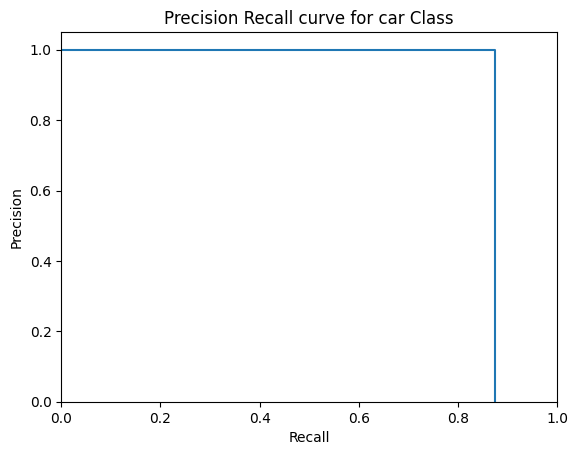

In [82]:
class_dict = results_dict[single_class]
def compute_ap_curve(class_dict):
    t_pos = 0
    class_dict['precision'] = np.ones(class_dict['result'].shape[0]+2)
    class_dict['recall'] = np.zeros(class_dict['result'].shape[0]+2)
    sorted_detections = class_dict['result'][(-class_dict['result'][:, 1]).argsort(), :]
    print(sorted_detections.shape)
    for i, (result_bool, result_score) in enumerate(sorted_detections):
        if result_bool == 1:
            t_pos += 1
        class_dict['precision'][i+1] = t_pos / (i + 1)
        class_dict['recall'][i+1] = t_pos / class_dict['total_N_pos']
    class_dict['precision'][i+2] = 0
    class_dict['recall'][i+2] = class_dict['recall'][i+1]

    ## Plot
    plt.figure()
    plt.plot(class_dict['recall'], class_dict['precision'])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision Recall curve for {} Class'.format(class_dict['class']))
    plt.xlim([0, 1])
    plt.ylim([0, 1.05])
    plt.savefig(save_loc + class_dict['class'] + "_pr_curve.png")
compute_ap_curve(class_dict)

In [83]:
def compute_mean_ap(precision, recall, precision_threshold=0.0, recall_threshold=0.0):
    mean_ap = 0
    threshold_mask = np.logical_and(precision > precision_threshold,
                                    recall > recall_threshold)
    # calculate mean AP
    precision = precision[threshold_mask]
    recall = recall[threshold_mask]
    recall_diff = np.diff(recall)
    precision_diff = np.diff(precision)
    # Square area under curve based on i+1 precision, then linear difference in precision
    mean_ap = np.sum(precision[1:]*recall_diff + recall_diff*precision_diff/2)
    # We need to divide by (1-recall_threshold) to make the max possible mAP = 1. In practice threshold by the first
    # considered recall value (threshold = 0.1 -> first considered value may be = 0.1123)
    mean_ap = mean_ap/(1-recall[0])
    return mean_ap
mean_ap = compute_mean_ap(class_dict['precision'], class_dict['recall'])
mean_ap

0.8571428571428571

In [ ]:
# 출처: https://github.com/jacoblambert/3d_lidar_detection_evaluation/blob/master/nuscenes_eval_core.py
from label_parser import LabelParser

class NuScenesEval:
    def __init__(self, pred_label_path, gt_label_path, label_format, save_loc,
                 classes=['car', 'pedestrian', 'cyclist'],
                 distance_threshold=1.0,
                 min_score=0.0,
                 max_range=0.0):

        # Initialize
        self.save_loc = save_loc
        self.distance_threshold_sq = distance_threshold**2
        self.score_threshold = min_score
        self.max_range = max_range
        self.classes = classes
        self.total_N_pos = 0
        self.results_dict = {}
        for single_class in classes:
            class_dict = {}
            class_dict['class'] = single_class
            class_dict['T_p'] = np.empty((0, 8))
            class_dict['gt'] = np.empty((0, 7))
            class_dict['total_N_pos'] = 0
            class_dict['result'] = np.empty((0, 2))
            class_dict['precision'] = []
            class_dict['recall'] = []
            self.results_dict[single_class] = class_dict
        # Format
        if pred_label_path[-1] is not "/":
            pred_label_path += "/"
        if gt_label_path[-1] is not "/":
            gt_label_path += "/"
        # Run
        self.time = time.time()
        self.evaluate(pred_label_path, gt_label_path, label_format)

    def evaluate(self, pred_path, gt_path, label_format):
        pred_file_list = glob.glob(pred_path + "*")
        pred_file_list.sort()
        gt_file_list = glob.glob(gt_path + "*")
        gt_file_list.sort()
        num_examples = len(pred_file_list)
        print("Starting evaluation for {} file predictions".format(num_examples))
        print("--------------------------------------------")

        ## Check missing files
        print("Confirmation prediction ground truth file pairs.")
        for pred_fn in pred_file_list:
            if (gt_path + os.path.basename(pred_fn)) not in gt_file_list:
                print("Error loading labels: gt label for pred label {} was not found.".format(
                    os.path.basename(pred_fn)))
                sys.exit(1)

        ## Evaluate matches
        print("Evaluation examples")
        file_parsing = LabelParser(label_format)
        for i, pred_fn in enumerate(pred_file_list):
            # print("\r", i+1, "/", num_examples, end="")
            gt_fn = gt_path + os.path.basename(pred_fn)
            predictions = file_parsing.parse_label(pred_fn, prediction=True)
            ground_truth = file_parsing.parse_label(gt_fn, prediction=False)
        # Filter range
            if self.max_range > 0:
                predictions, ground_truth = self.filter_by_range(predictions, ground_truth, range=self.max_range)
            self.eval_pair(predictions, ground_truth)
        print("\nDone!")
        print("----------------------------------")
        ## Calculate
        for single_class in self.classes:
            class_dict = self.results_dict[single_class]
            print("Calculating metrics for {} class".format(single_class))
            print("----------------------------------")
            print("Number of ground truth labels: ", class_dict['total_N_pos'])
            print("Number of detections:  ", class_dict['result'].shape[0])
            print("Number of true positives:  ", np.sum(class_dict['result'][:, 0] == 1))
            print("Number of false positives:  ", np.sum(class_dict['result'][:, 0] == 0))
            if class_dict['total_N_pos'] == 0:
                print("No detections for this class!")
                print(" ")
                continue
            ## AP
            self.compute_ap_curve(class_dict)
            mean_ap = self.compute_mean_ap(class_dict['precision'], class_dict['recall'])
            print('Mean AP: %.3f ' % mean_ap)
            f1 = self.compute_f1_score(class_dict['precision'], class_dict['recall'])
            print('F1 Score: %.3f ' % f1)
            print(' ')
            ## Positive Thresholds
            # ATE 2D
            ate2d = self.compute_ate2d(class_dict['T_p'], class_dict['gt'])
            print('Average 2D Translation Error [m]:  %.4f ' % ate2d)
            # ATE 3D
            ate3d = self.compute_ate3d(class_dict['T_p'], class_dict['gt'])
            print('Average 3D Translation Error [m]:  %.4f ' % ate3d)
            # ASE
            ase = self.compute_ase(class_dict['T_p'], class_dict['gt'])
            print('Average Scale Error:  %.4f ' % ase)
            # AOE
            aoe = self.compute_aoe(class_dict['T_p'], class_dict['gt'])
            print('Average Orientation Error [rad]:  %.4f ' % aoe)
            print(" ")
        self.time = float(time.time() - self.time)
        print("Total evaluation time: %.5f " % self.time)

    def compute_ap_curve(self, class_dict):
        t_pos = 0
        class_dict['precision'] = np.ones(class_dict['result'].shape[0]+2)
        class_dict['recall'] = np.zeros(class_dict['result'].shape[0]+2)
        sorted_detections = class_dict['result'][(-class_dict['result'][:, 1]).argsort(), :]
        print(sorted_detections.shape)
        for i, (result_bool, result_score) in enumerate(sorted_detections):
            if result_bool == 1:
                t_pos += 1
            class_dict['precision'][i+1] = t_pos / (i + 1)
            class_dict['recall'][i+1] = t_pos / class_dict['total_N_pos']
        class_dict['precision'][i+2] = 0
        class_dict['recall'][i+2] = class_dict['recall'][i+1]

        ## Plot
        plt.figure()
        plt.plot(class_dict['recall'], class_dict['precision'])
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision Recall curve for {} Class'.format(class_dict['class']))
        plt.xlim([0, 1])
        plt.ylim([0, 1.05])
        plt.savefig(self.save_loc + class_dict['class'] + "_pr_curve.png")

    def compute_f1_score(self, precision, recall):
        p, r = precision[(precision+recall) > 0], recall[(precision+recall) > 0]
        f1_scores = 2 * p * r / (p + r)
        return np.max(f1_scores)

    def compute_mean_ap(self, precision, recall, precision_threshold=0.0, recall_threshold=0.0):
        mean_ap = 0
        threshold_mask = np.logical_and(precision > precision_threshold,
                                        recall > recall_threshold)
        # calculate mean AP
        precision = precision[threshold_mask]
        recall = recall[threshold_mask]
        recall_diff = np.diff(recall)
        precision_diff = np.diff(precision)
        # Square area under curve based on i+1 precision, then linear difference in precision
        mean_ap = np.sum(precision[1:]*recall_diff + recall_diff*precision_diff/2)
        # We need to divide by (1-recall_threshold) to make the max possible mAP = 1. In practice threshold by the first
        # considered recall value (threshold = 0.1 -> first considered value may be = 0.1123)
        mean_ap = mean_ap/(1-recall[0])
        return mean_ap

    def compute_ate2d(self, predictions, ground_truth):
        # euclidean distance 3d
        mean_ate2d = np.mean(np.sqrt((predictions[:, 0] - ground_truth[:, 0])**2 +
                                     (predictions[:, 1] - ground_truth[:, 1])**2))
        return mean_ate2d

    def compute_ate3d(self, predictions, ground_truth):
        # euclidean distance 2d
        mean_ate3d = np.mean(np.sqrt((predictions[:, 0] - ground_truth[:, 0]) ** 2 +
                                     (predictions[:, 1] - ground_truth[:, 1]) ** 2 +
                                     (predictions[:, 2] - ground_truth[:, 2]) ** 2))
        return mean_ate3d

    def compute_ase(self, predictions, ground_truth):
        # simplified iou where boxes are centered and aligned with eachother
        pred_vol = predictions[:, 3:6]
        gt_vol = ground_truth[:, 3:6]
        iou3d = np.mean(1 - np.prod(np.minimum(pred_vol, gt_vol), axis=1)/np.prod(np.maximum(pred_vol, gt_vol), axis=1))
        return iou3d

    def compute_aoe(self, predictions, ground_truth):
        err = ground_truth[:,6] - predictions[:,6]
        aoe = np.mean(np.abs((err + np.pi) % (2*np.pi) - np.pi))
        return aoe

    def eval_pair(self, pred_label, gt_label):
        ## Check
        assert pred_label.shape[1] == 9
        assert gt_label.shape[1] == 8

        ## Threshold score
        if pred_label.shape[0] > 0:
            pred_label = pred_label[pred_label[:, 8].astype(np.float) > self.score_threshold, :]

        for single_class in self.classes:
            # get all pred labels, order by score
            class_pred_label = pred_label[np.char.lower(pred_label[:, 0].astype(str)) == single_class, 1:]
            score = class_pred_label[:, 7].astype(np.float)
            class_pred_label = class_pred_label[(-score).argsort(), :].astype(np.float) # sort decreasing

            # add gt label length to total_N_pos
            class_gt_label = gt_label[np.char.lower(gt_label[:, 0].astype(str)) == single_class, 1:].astype(np.float)
            self.results_dict[single_class]['total_N_pos'] += class_gt_label.shape[0]

            # match pairs
            pred_array, gt_array, result_score_pair = self.match_pairs(class_pred_label, class_gt_label)

            # add to existing results
            self.results_dict[single_class]['T_p'] = np.vstack((self.results_dict[single_class]['T_p'], pred_array))
            self.results_dict[single_class]['gt'] = np.vstack((self.results_dict[single_class]['gt'], gt_array))
            self.results_dict[single_class]['result'] = np.vstack((self.results_dict[single_class]['result'],
                                                                   result_score_pair))

    def match_pairs(self, pred_label, gt_label):
        true_preds = np.empty((0, 8))
        corresponding_gt = np.empty((0, 7))
        result_score = np.empty((0, 2))
        # Initialize matching loop
        match_incomplete = True
        while match_incomplete and gt_label.shape[0] > 0:
            match_incomplete = False
            for gt_idx, single_gt_label in enumerate(gt_label):
                # Check is any prediction is in range
                distance_sq_array = (single_gt_label[0] - pred_label[:, 0])**2 + (single_gt_label[1] - pred_label[:, 1])**2
                # If there is a prediction in range, pick closest
                if np.any(distance_sq_array < self.distance_threshold_sq):
                    min_idx = np.argmin(distance_sq_array)
                    # Store true prediction
                    true_preds = np.vstack((true_preds, pred_label[min_idx, :].reshape(-1, 1).T))
                    corresponding_gt = np.vstack((corresponding_gt, gt_label[gt_idx]))

                    # Store score for mAP
                    result_score = np.vstack((result_score, np.array([[1, pred_label[min_idx, 7]]])))

                    # Remove prediction and gt then reset loop
                    pred_label = np.delete(pred_label, obj=min_idx, axis=0)
                    gt_label = np.delete(gt_label, obj=gt_idx, axis=0)
                    match_incomplete = True
                    break

        # If there were any false detections, add them.
        if pred_label.shape[0] > 0:
            false_positives = np.zeros((pred_label.shape[0], 2))
            false_positives[:, 1] = pred_label[:, 7]
            result_score = np.vstack((result_score, false_positives))
        return true_preds, corresponding_gt, result_score

    def filter_by_range(self, pred_label, gt_label, range=0):
        pred_dist = np.linalg.norm(pred_label[:, 1:4].astype(np.float32), axis=1) < range
        gt_dist = np.linalg.norm(gt_label[:, 1:4].astype(np.float32), axis=1) < range
        return pred_label[pred_dist, :], gt_label[gt_dist, :]